WeGo Public Transit

WeGo Public Transit is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

In this project, you'll be analyzing the bus spacing to look for patterns and try to identify correlations to controllable or external factors. Specifically, you'll be using a dataset containing information on the headway, or amount of time between vehicle arrivals at a stop. This dataset contains a column HDWY_DEV, which shows the headway deviation. This variable will be negative when bunching has occurred (shorter headway than scheduled) and will be positive for gapping (longer headway than scheduled). Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY.

#### Goals of this project:

How much impact does being late or too spaced out at the first stop have downstream?

What is the impact of the layover at the start of the trip (the difference between the first top arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?

How closely does lateness (ADHERENCE) correlate to headway?

What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has travelled?

How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

How does direction of travel, route, or location affect the headway and on-time performance?

#### How does time of day or day of week affect headway and on-time performance? Can you detect an impact of school schedule on headway deviation (for certain routes and at certain times of day)?

#### Does weather have any effect on headway or on-time performance? To help answer this question, the file bna_weather.csv contains historical weather data recorded at Nashville International Airport.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
%matplotlib inline


In [2]:
transit_df = pd.read_csv(r"C:\Users\ndidi\Documents\NSS_Projects\wego-creepin-it-real-wego\Data\headway_data_with_datetimes.csv", index_col=False)
pd.set_option('display.max_columns', None)

transit_df.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS
0,120230801,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,2023-08-01 - 345104,22,ON TIME
1,120230801,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,2023-08-01 - 345104,22,ON TIME
2,120230801,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,2023-08-01 - 345104,22,ON TIME
3,120230801,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,2023-08-01 - 345104,22,ON TIME
4,120230801,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,2023-08-01 - 345105,22,ON TIME


In [3]:
# convert date & time variables to datetime

transit_df['SCHEDULED_TIME'] = pd.to_datetime(transit_df['SCHEDULED_TIME'])
transit_df['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(transit_df['ACTUAL_ARRIVAL_TIME'])
transit_df['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(transit_df['ACTUAL_DEPARTURE_TIME'])

In [4]:
transit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  object        
 4   ROUTE_ABBR                 350328 non-null  object        
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64 

In [5]:
transit_df['HDWY_DEV_PER'] = transit_df['HDWY_DEV']/transit_df['SCHEDULED_HDWY']
transit_df

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS,HDWY_DEV_PER
0,120230801,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,2023-08-01 - 345104,22,ON TIME,NaN
1,120230801,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,2023-08-01 - 345104,22,ON TIME,NaN
2,120230801,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,2023-08-01 - 345104,22,ON TIME,NaN
3,120230801,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,2023-08-01 - 345104,22,ON TIME,NaN
4,120230801,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,2023-08-01 - 345105,22,ON TIME,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,2023-09-30,HILLSBORO,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,2023-09-30 - 353448,7,LATE,0.175556
350324,120230930,2,100406611,2023-09-30,HILLSBORO,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,2023-09-30 - 353448,7,LATE,NaN
350325,120230930,2,100406612,2023-09-30,HILLSBORO,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,2023-09-30 - 353449,7,ON TIME,0.062222
350326,120230930,2,100406613,2023-09-30,HILLSBORO,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,2023-09-30 - 353449,7,LATE,0.583333


## 7) How does time of day or day of week affect headway and on-time performance? Can you detect an impact of school schedule on headway deviation (for certain routes and at certain times of day)?

### How does time of day affect headway?

headway: amount of time between vehicle arrivals at a stop

larger headway value -> late bus?

smaller headway value -> on time or early bus?

In [6]:
# headway focuses on arrivals between stops so retrieve arrival hours & make new column in df

transit_df['ACTUAL_ARRIVAL_HOUR'] = transit_df['ACTUAL_ARRIVAL_TIME'].dt.hour
transit_df.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS,HDWY_DEV_PER,ACTUAL_ARRIVAL_HOUR
0,120230801,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,2023-08-01 - 345104,22,ON TIME,NaN,4.0
1,120230801,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,2023-08-01 - 345104,22,ON TIME,NaN,4.0
2,120230801,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,2023-08-01 - 345104,22,ON TIME,NaN,4.0
3,120230801,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,2023-08-01 - 345104,22,ON TIME,NaN,5.0
4,120230801,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,2023-08-01 - 345105,22,ON TIME,NaN,5.0


In [7]:
# aggregate for hour column of dataframe
transit_df['ACTUAL_ARRIVAL_HOUR'].describe() # -> hour 13 (1pm) is mean;

count    338869.000000
mean         13.075439
std           5.198017
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          23.000000
Name: ACTUAL_ARRIVAL_HOUR, dtype: float64

In [8]:
transit_df['ACTUAL_HDWY'].describe()

count    266061.000000
mean         18.648567
std          14.330594
min           0.000000
25%          11.000000
50%          16.183333
75%          23.250000
max         590.433333
Name: ACTUAL_HDWY, dtype: float64

In [9]:
transit_df['SCHEDULED_HDWY'].describe()

count    274737.000000
mean         18.186040
std          12.261828
min           0.000000
25%          10.000000
50%          15.000000
75%          20.000000
max         503.000000
Name: SCHEDULED_HDWY, dtype: float64

<Axes: >

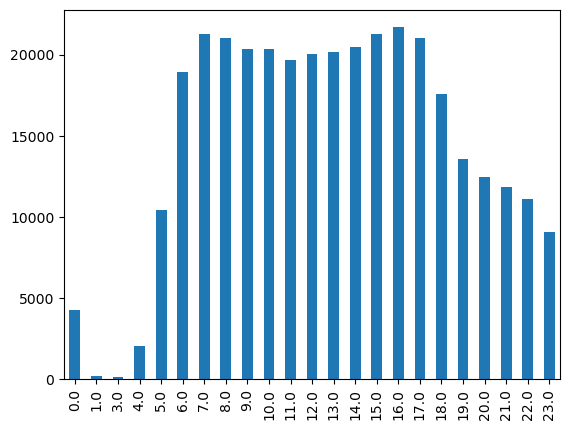

In [10]:
# arrivals for each hour
transit_df['ACTUAL_ARRIVAL_HOUR'].value_counts().sort_index().plot(kind = 'bar')

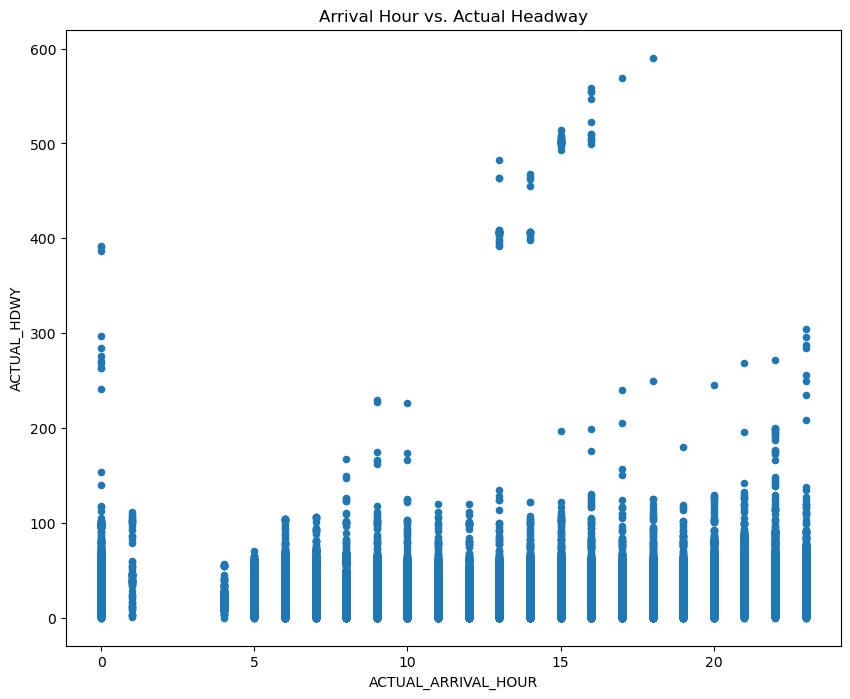

In [11]:
# scatter plot hour vs actual_hdwy

transit_df.plot(kind = 'scatter', x = 'ACTUAL_ARRIVAL_HOUR', y = 'ACTUAL_HDWY', figsize = (10,8))
plt.title('Arrival Hour vs. Actual Headway'); # -> 17 - 18 (5pm-6pm) have largest headway values
# -> 13 - 16 (1pm-4pm) seem to have more frequent headway? 
# -> 0 (12am) also has significant headway but not as much as other times

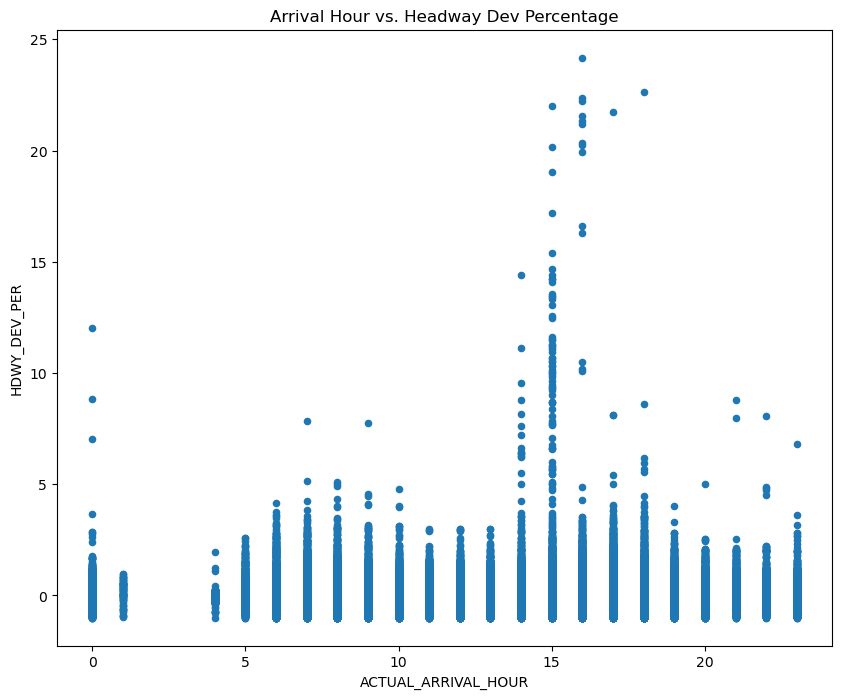

In [12]:
transit_df.plot(kind = 'scatter', x = 'ACTUAL_ARRIVAL_HOUR', y = 'HDWY_DEV_PER', figsize = (10,8))
plt.title('Arrival Hour vs. Headway Dev Percentage');

# keeping this graph for now but still trying to decipher if it is useful or not

### How does time of day affect on-time performance?

In [13]:
transit_df['ARRIVAL_STATUS'].nunique()

3

In [14]:
# frequency of arrival status
transit_df['ARRIVAL_STATUS'].value_counts() # -> convert this to percentage later to find percentage of ontime/late/early buses

ON TIME    270047
LATE        59038
EARLY        9775
Name: ARRIVAL_STATUS, dtype: int64

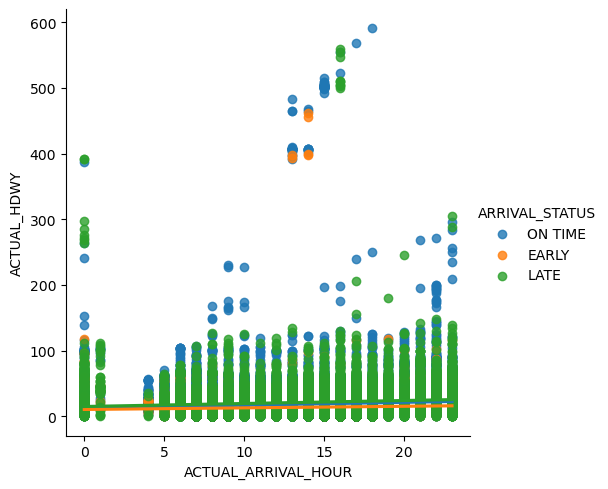

In [15]:
# trellis plot
sns.lmplot(x='ACTUAL_ARRIVAL_HOUR', y ='ACTUAL_HDWY',hue='ARRIVAL_STATUS',data=transit_df)

In [ ]:
#transit_df['ARRIVAL_STATUS'].value_counts().plot(kind = 'bar')

In [ ]:
# frequency of arrival status in bar graph
#sns.catplot(data=transit_df, x='ARRIVAL_STATUS', kind='count')

### How does day of week affect headway? 
headway: amount of time between vehicle arrivals at a stop

In [17]:
# confirming values -> should only be 3 values
transit_df['SERVICE_ABBR'].unique() # 1 -> weekday; 2 -> saturday; 3 -> sunday; labor day (9-4-2023) is the holiday

array([1, 2, 3], dtype=int64)

In [23]:
# find day of week

# day of week output is numerical
transit_df['DAY_OF_WEEK_NUMBER'] = transit_df['ACTUAL_ARRIVAL_TIME'].dt.weekday

# day of week output is categorical
transit_df['DAY_OF_WEEK'] = transit_df['ACTUAL_ARRIVAL_TIME'].dt.day_name()

transit_df.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS,HDWY_DEV_PER,ACTUAL_ARRIVAL_HOUR,DAY_OF_WEEK_NUMBER,DAY_OF_WEEK
0,120230801,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,2023-08-01 - 345104,22,ON TIME,NaN,4.0,1.0,Tuesday
1,120230801,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,2023-08-01 - 345104,22,ON TIME,NaN,4.0,1.0,Tuesday
2,120230801,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,2023-08-01 - 345104,22,ON TIME,NaN,4.0,1.0,Tuesday
3,120230801,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,2023-08-01 - 345104,22,ON TIME,NaN,5.0,1.0,Tuesday
4,120230801,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,2023-08-01 - 345105,22,ON TIME,NaN,5.0,1.0,Tuesday


In [24]:
transit_df.tail() 
# mon : 0, tues: 1, wed: 2, thur: 3, fri: 4, sat: 5, sun: 6

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS,HDWY_DEV_PER,ACTUAL_ARRIVAL_HOUR,DAY_OF_WEEK_NUMBER,DAY_OF_WEEK
350323,120230930,2,100406610,2023-09-30,HILLSBORO,702,2312,353448,0,TO DOWNTOWN,21BK,4.0,0,36.138372,-86.800622,2023-09-30 22:23:00,2023-09-30 22:31:26,2023-09-30 22:31:26,-8.433333,30.0,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000,2023-09-30 - 353448,7,LATE,0.175556,22.0,5.0,Saturday
350324,120230930,2,100406611,2023-09-30,HILLSBORO,702,2312,353448,0,TO DOWNTOWN,MCC5_9,3.0,2,36.167091,-86.781923,2023-09-30 22:38:00,2023-09-30 22:49:18,2023-09-30 22:49:18,-11.300000,NaN,NaN,NaN,0,1,0,0,NaN,0,551,0.000000,2023-09-30 - 353448,7,LATE,NaN,22.0,5.0,Saturday
350325,120230930,2,100406612,2023-09-30,HILLSBORO,702,2312,353449,0,FROM DOWNTOWN,MCC5_9,3.0,1,36.167091,-86.781923,2023-09-30 22:45:00,2023-09-30 22:49:19,2023-09-30 22:49:19,-4.316666,30.0,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000,2023-09-30 - 353449,7,ON TIME,0.062222,22.0,5.0,Saturday
350326,120230930,2,100406613,2023-09-30,HILLSBORO,702,2312,353449,0,FROM DOWNTOWN,21BK,4.0,0,36.138881,-86.800622,2023-09-30 22:59:00,2023-09-30 23:21:05,2023-09-30 23:21:05,-22.083333,30.0,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000,2023-09-30 - 353449,7,LATE,0.583333,23.0,5.0,Saturday
350327,120230930,2,100406614,2023-09-30,HILLSBORO,702,2312,353449,0,FROM DOWNTOWN,HBHS,5.0,2,36.107575,-86.812719,2023-09-30 23:11:00,2023-09-30 23:31:27,2023-09-30 23:34:40,-23.666666,NaN,NaN,NaN,0,1,0,0,NaN,0,577,3.216666,2023-09-30 - 353449,7,LATE,NaN,23.0,5.0,Saturday


In [25]:
transit_df['DAY_OF_WEEK'].count()

338869

In [27]:
transit_df['DAY_OF_WEEK_NUMBER'].count()

338869

In [ ]:
#transit_df['ACTUAL_ARRIVAL_TIME'].count()

In [26]:
transit_df['DAY_OF_WEEK'].value_counts()

Wednesday    56928
Tuesday      56626
Thursday     56290
Friday       55812
Monday       47447
Saturday     36456
Sunday       29310
Name: DAY_OF_WEEK, dtype: int64

In [28]:
transit_df['DAY_OF_WEEK_NUMBER'].value_counts()

2.0    56928
1.0    56626
3.0    56290
4.0    55812
0.0    47447
5.0    36456
6.0    29310
Name: DAY_OF_WEEK_NUMBER, dtype: int64

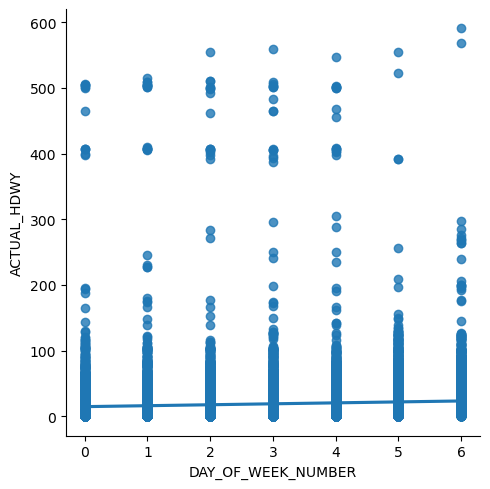

In [33]:
sns.lmplot(x='DAY_OF_WEEK_NUMBER', y ='ACTUAL_HDWY',data=transit_df)

<Axes: title={'center': 'ACTUAL_HDWY'}, xlabel='DAY_OF_WEEK_NUMBER'>

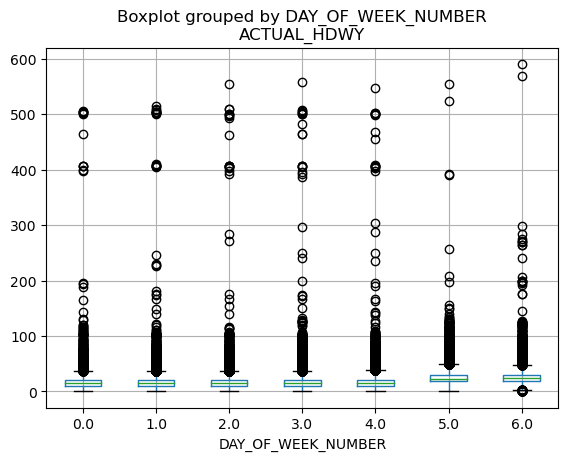

In [34]:
transit_df.boxplot(column='ACTUAL_HDWY', by='DAY_OF_WEEK_NUMBER')

In [ ]:
# scatter plot day of week vs actual_hdwy

#transit_df.plot(kind = 'scatter', x = 'DAY_OF_WEEK', y = 'HDWY_DEV', figsize = (10,8))
#plt.title('Day of Week vs. Actual Headway');

#plt.figure(figsize=(18,10))
#ax = sns.histplot(x='DAY_OF_WEEK', y='HDWY_DEV', data=transit_df)

In [ ]:
#sns.histplot(x='DAY_OF_WEEK', y='HDWY_DEV', data=transit_df)

### How does day of week affect on-time performance? 

In [ ]:
#per Michael: try to look at percentages

<Axes: xlabel='DAY_OF_WEEK', ylabel='Percent'>

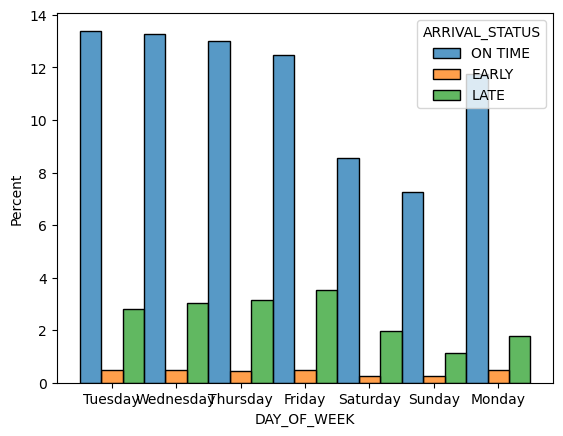

In [44]:
sns.histplot(binwidth=0.5, x="DAY_OF_WEEK", hue="ARRIVAL_STATUS", data=transit_df, stat="percent", multiple="dodge")


### Can you detect an impact of school schedule on headway deviation (for certain routes and at certain times of day)?